In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set seed for reproducibilityz
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# class_names_map = {
#     0: "Accident",
#     1: "Sexual Harassment",
#     2: "Blood",
#     3: "Blood and Gore",
#     4: "Explosion",
#     5: "Violence",
#     6: "nudity",
#     7: "Suicide"
# }

# def convert_yolo_to_classification(yolo_folder, output_folder):
#     image_folder = os.path.join(yolo_folder, "images")
#     label_folder = os.path.join(yolo_folder, "labels")
#     for label_file in os.listdir(label_folder):
#         label_path = os.path.join(label_folder, label_file)
#         with open(label_path, "r") as f:
#             first_line = f.readline().strip()
#             if not first_line:
#                 continue
#             class_id = int(first_line.split()[0])
#             class_name = class_names_map[class_id]
#         class_dir = os.path.join(output_folder, class_name)
#         os.makedirs(class_dir, exist_ok=True)
#         img_file = label_file.replace(".txt", ".jpg")
#         src_img_path = os.path.join(image_folder, img_file)
#         dst_img_path = os.path.join(class_dir, img_file)
#         if os.path.exists(src_img_path):
#             shutil.copy(src_img_path, dst_img_path)

In [ ]:
# convert_yolo_to_classification("dataset/train", "converted/train")
# convert_yolo_to_classification("dataset/valid", "converted/valid")
# convert_yolo_to_classification("dataset/test", "converted/test")

In [3]:
train_dir = 'converted/train'
val_dir = 'converted/valid'
test_dir = 'converted/test'
img_size = (224, 224)
batch_size = 32
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['Accident', 'Blood', 'Blood and Gore', 'Explosion', 'Normal', 'Sexual Harassment', 'Suicide', 'Violence', 'nudity']


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 2570 images belonging to 9 classes.
Found 743 images belonging to 9 classes.
Found 366 images belonging to 9 classes.


In [5]:
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.532627865961199, 1: 8.653198653198654, 2: 6.640826873385013, 3: 14.277777777777779, 4: 0.8473458621826574, 5: 0.7284580498866213, 6: 7.932098765432099, 7: 3.3994708994708995, 8: 0.18281405605349269}


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Kompilasi ulang
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 1,691,529 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights
)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 683ms/step - accuracy: 0.6230 - loss: 1.2225 - val_accuracy: 0.8048 - val_loss: 0.8542
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 662ms/step - accuracy: 0.6553 - loss: 1.0857 - val_accuracy: 0.8156 - val_loss: 0.7944
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 663ms/step - accuracy: 0.6910 - loss: 1.0693 - val_accuracy: 0.8264 - val_loss: 0.7425
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 699ms/step - accuracy: 0.7035 - loss: 1.0302 - val_accuracy: 0.8371 - val_loss: 0.6993
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 710ms/step - accuracy: 0.6927 - loss: 0.9523 - val_accuracy: 0.8371 - val_loss: 0.6591
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.7377 - loss: 0.8749 - val_accuracy: 0.8479 - val_loss: 0.6246
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 618ms/step - accuracy: 0.7459 - loss: 0.7527 - val_accuracy: 0.8546 - val_loss: 0.5982
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.7290 - loss: 0.9062 - val_accu

366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8793 - loss: 0.4199
Test Accuracy: 0.9043715596199036
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


<Figure size 1000x1000 with 0 Axes>

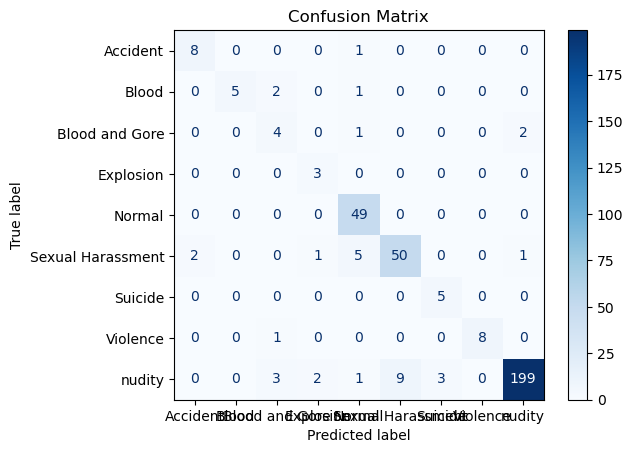

In [9]:
loss, acc = model.evaluate(test_generator)
print("Test Accuracy:", acc)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def predict_image_from_file(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    print("Predicted Class:", predicted_class)
    plt.imshow(img)
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Class: Normal


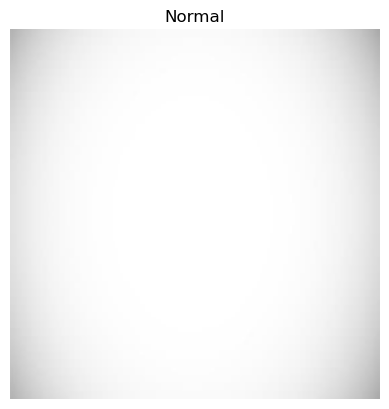

In [ ]:
predict_image_from_file('https://marketplace.canva.com/VUYrU/MAEYu6VUYrU/1/tl/canva-bright-gradient-background-MAEYu6VUYrU.jpg')